# 01. Introduction
### Feature analysis
### Feature engineering
### Modeling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white',context='notebook',palette='deep')

# 02. Load and check data
## 2.1 Load data

In [4]:
# Load data
##### Load train and Test set

train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')
IDtest = test['PassengerId']

## 2.2 Outlier detection

In [5]:
# Outlier detection

def detect_outliers(df, n, features):
    """
    Takes a dataframe df of feature and returns a list of the indices 
    corresponding to the observations containing more than n outliers 
    according to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col],25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step 
        outlier_step = 1.5*IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1-outlier_step) | (df[col] > Q3+outlier_step)].index
        
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v>n)
        
    return multiple_outliers
    
# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ["Age","SibSp","Parch","Fare"])

- 이상치 값들이 예측에 엄청난 영향을 미칠 수 있으므로 관리하는 것이 좋다.
- Tukey method 방식을 이용하여 수치형 자료 feature들의 이상치를 감지했다.

In [6]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


- 10개의 이상치 발견
- 28,89,342번의 승객들은 티겟값이 매우 높다
- SibSp에서 7개의 높은 이상치가 발견되었다.

In [7]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 2.3 joining train and test set

In [8]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train,test],axis=0).reset_index(drop=True)

- 범주 변환 중에 동일한 수의 기능을 얻기 위해 훈련 및 테스트 데이터 세트를 join(기능 엔지니어링 참조)  

## 2.4 check for null and missing values

In [9]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

- Age와 Cabin feature에는 결측값의 중요한 부분이 있다.
- Survived missing values는 조인 테스트 데이터 세트에 해당(남아 있는 열은 테스트 세트에 존재하지 않으며 열차와 테스트 세트를 연결할 때 NaN 값으로 대체됨).

In [10]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [13]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 03. Feature analysis
## 3.1 Numerical values

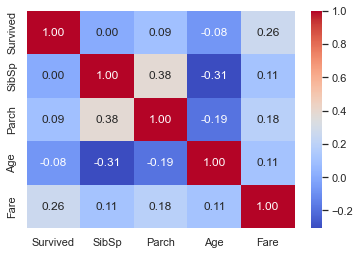

In [14]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot=True, fmt=".2f",cmap="coolwarm")

- Fare feature만이 Survived feature와 유의미한 상관관계가 있는 것으로 보인다.
- 다른 feature들이 유용하지 않다는 의미는 아니다. 이 feature들의 하위 모집단은 Survived과 상관 관계가 있을 수 있다. 이를 확인하려면 이러한 기능을 자세히 탐색해야 한다.

### SibSP

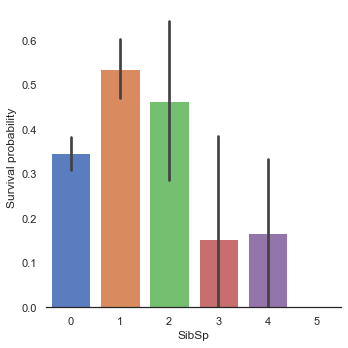

In [17]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="SibSp",y="Survived",data=train, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival probability")

- siblings/spouses가 많은 탑승객들은 생존확률이 적어보인다.
- 혼자인 탑승객 또는 두명으로 이뤄진 탑승객이 생존할 확률이 더 높다.
- 우리는 이 결과를 보고 SibSp feature의 범주를 설명하는 새로운 feature를 고려할 수 있다.

### Parch

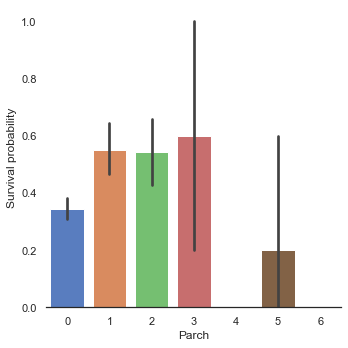

In [18]:
# Explore Parch feature vs Survived
g = sns.catplot(x="Parch",y="Survived",data=train, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival probability")

- 작은 가족단위가 생존할 확률이 더 높다, 한명으로 이뤄진 가족이나 3,4 또는 그 이상으로 이뤄진 가족단위보다.
- 3명의 부모/자녀가 있는 승객의 생존에 중요한 표준 편차가 있음을 주의해야한다.

### Age

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwar

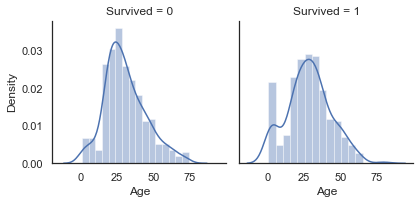

In [19]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col="Survived")
g = g.map(sns.distplot, "Age")

- Age의 분포는 꼬리분포를 가진 가우시안 분포처럼 보인다.
- 생존 하위 집단과 생존하지 못한 하위 집단에서 연령 분포가 동일하지 않음을 알 수 있다. 실제로 살아남은 젊은 승객에 해당하는 피크가 있다. 또한 60-80세 사이의 승객이 덜 살아남았다는 것을 알 수 있다.
- 따라서 Age가 Survived과 상관관계가 없더라도 생존할 가능성이 있는 승객의 연령 범주가 있음을 알 수 있다.
- 매우 어린 탑승객일수록 생존 확률이 높다는 것을 볼 수 있다.

/var/folders/qg/syyr2wld1c5gxxwxs5pkpty80000gn/T/ipykernel_36343/3602212169.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"]==0)&(train["Age"].notnull())],color="Red", shade=True)
/var/folders/qg/syyr2wld1c5gxxwxs5pkpty80000gn/T/ipykernel_36343/3602212169.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"]==1)&(train["Age"].notnull())], ax=g, color="Blue",shade=True)


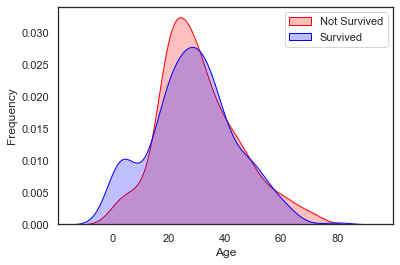

In [20]:
# Explore Age distribution
g = sns.kdeplot(train["Age"][(train["Survived"]==0)&(train["Age"].notnull())],color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"]==1)&(train["Age"].notnull())], ax=g, color="Blue",shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

- 두 밀도를 중첩하면 아기와 아주 어린 아이들에게 해당하는 피크(0에서 5 사이)를 명확하게 볼 수 있다.

### Fare

In [21]:
dataset["Fare"].isnull().sum()

1

In [22]:
# Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

/var/folders/qg/syyr2wld1c5gxxwxs5pkpty80000gn/T/ipykernel_36343/1683769913.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))


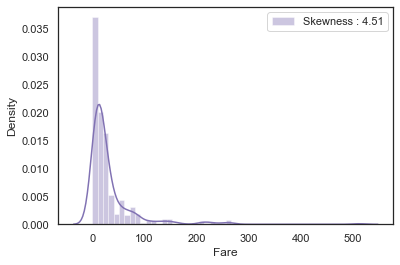

In [23]:
# Explore Fare distribution
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- Fare feature의 왜도가 심한 것을 볼 수 있다. 
- 이로 인해 크기가 조정되더라도 모델에서 매우 높은 값이 초과될 수 있다.
- 이 경우 이 왜곡을 줄이기 위해 로그 함수로 변환하는 것이 좋다.

In [24]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i : np.log(i) if i>0 else 0)

/var/folders/qg/syyr2wld1c5gxxwxs5pkpty80000gn/T/ipykernel_36343/3934638641.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"],color="b",label="Skewness : %.2f"%(dataset["Fare"].skew()))


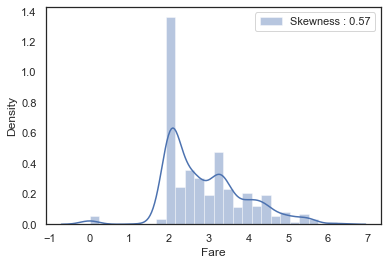

In [25]:
g = sns.distplot(dataset["Fare"],color="b",label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- 로그 변환을 통해 왜곡이 많이 준 것을 볼 수 있다.

## 3.2 Categorical values
### Sex

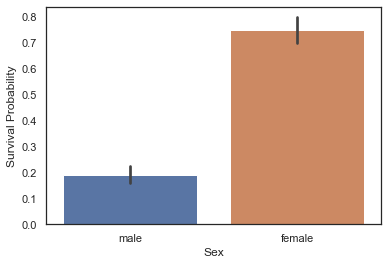

In [26]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [27]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 남성이 여성보다 생존확률이 낮다는 것을 명확히 알 수 있다.
- 따라서 "Sex"는 생존 예측에서 중요한 feature일 것이다. 

### Pclass

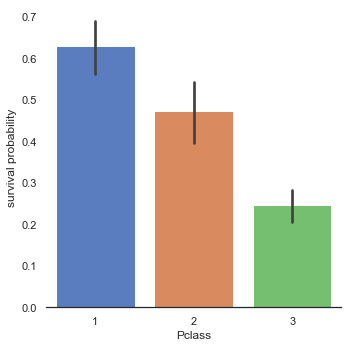

In [28]:
# Explore Pclass vs Survived
g = sns.catplot(x="Pclass",y="Survived",data=train, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

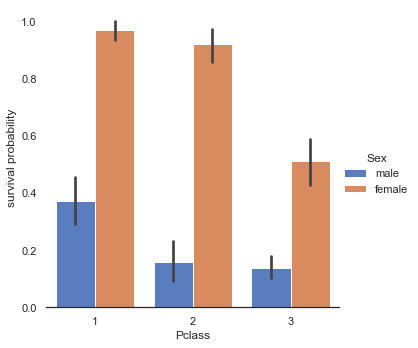

In [29]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(x="Pclass",y="Survived",hue="Sex",data=train,kind="bar",palette="muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

- 승객의 생존은 3개의 클래스에서 동일하지 않다. 1등석 승객은 2등석과 3등석 승객보다 생존할 확률이 더 높다.
- 이러한 경향은 남성 승객과 여성 승객 모두 같다.

### Embarked

In [30]:
dataset["Embarked"].isnull().sum()

2

In [31]:
# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

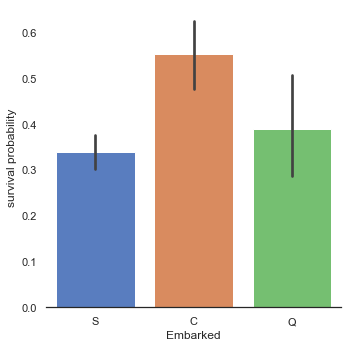

In [32]:
# Explore Embarked vs Survived
g = sns.catplot(x="Embarked",y="Survived",data=train,kind="bar",palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- Cherbourg (C)에서 오는 승객은 생존 가능성이 더 높은 것 같다.
- Queenstown(Q), Southampton(S)보다 Cherbourg(C)에서 온 승객의 일등석 승객 비율이 더 높을 수 있을 것 같다.

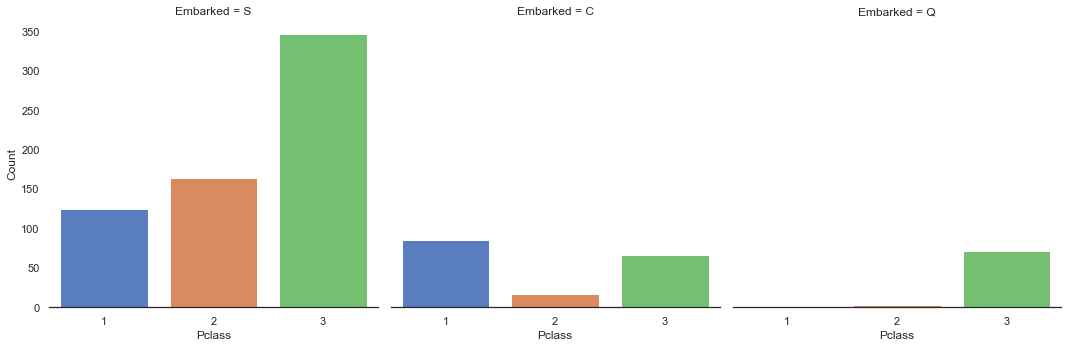

In [33]:
# Explor Pclass vs Embarked
g = sns.catplot(x="Pclass", col="Embarked",data=train,kind="count",palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

- 실제로 3등석은 Southampton(S)과 Queenstown(Q)에서 오는 승객이 가장 많이 이용하는 반면 Cherbourg(C) 승객은 대부분 생존율이 가장 높은 1등석이다.
- 이 시점에서 왜 일등석이 생존율이 더 높은지 설명할 수는 없다. 아마 일등석 승객이 그들의 영향으로 인해 대피 중에 우선 순위를 받았을 수 있다는 것이다.

# 04. Filling missing Values
## 4.1 Age
- Age에서 어린 아이들과 같이 낮은 연령대가 생존 확률이 더 높다. 이것은 age fature를 유지하고 결측치를 대치하는 것이 좋아보인다.
- 이 문제를 해결하기 위해 나이(Sex, Parch, Pclass 및 SibSP)와 가장 상관관계가 높은 기능을 살펴보자.

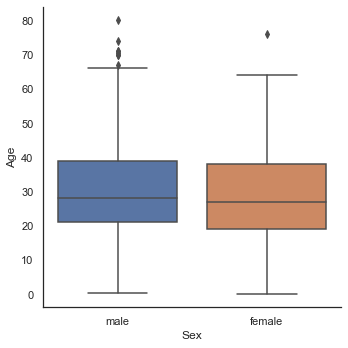

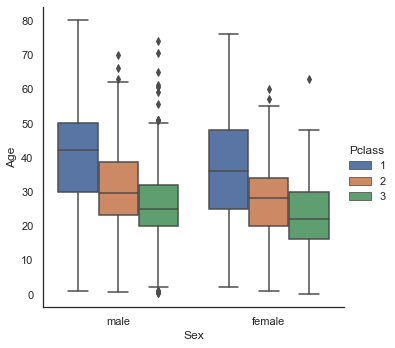

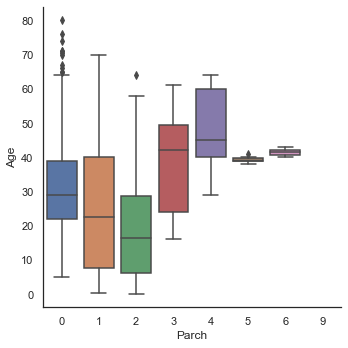

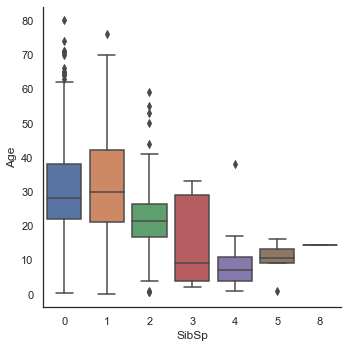

In [34]:
# Explore Age vs Sex, Parch, Pclass and SibSP
g = sns.catplot(y="Age", x="Sex", data=dataset, kind="box")
g = sns.catplot(y="Age", x="Sex", hue = "Pclass", data=dataset, kind="box")
g = sns.catplot(y="Age", x="Parch", data=dataset, kind="box")
g = sns.catplot(y="Age", x="SibSp", data=dataset, kind="box")

- Age는 남성과 여성 하위 모집단에서 동일한 것으로 보이므로 Sex은 Age을 예측하는 데 유익하지 않다.
- 그러나 1등석 승객은 2등석 승객보다 나이가 많고 3등석 승객보다 나이가 많다.
- 또한 부모/자녀가 많을수록 나이가 많고 형제자매/배우자가 많을수록 젊다.

In [35]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male":0, "female":1})

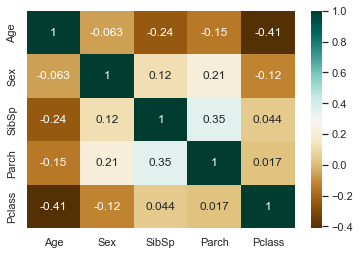

In [36]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(), cmap="BrBG",annot=True)

- 상관관게 맵은 Parch를 제외한 catplots 관찰을 확인한다. Age는 Sex와 상관관계가 없지만 Pclass, Parch 및 SibSp와는 음의 상관관계가 있다.
- Parch의 함수인 Age의 plot에서 나이는 부모/자식의 수와 함께 성장하고 있다. 그러나 일반적인 상관관계는 음수입니다.
- 결측치 값을 채우기 위해 SibSP, Parch, Pclass 사용
- Pclass, Parch 및 SibSp에 따라 유사한 행의 중앙값 Age로 Age를 채우기

In [39]:
# Filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp']==dataset.iloc[i]["SibSp"])&(dataset["Parch"]==dataset.iloc[i]["Parch"])&(dataset['Pclass']==dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


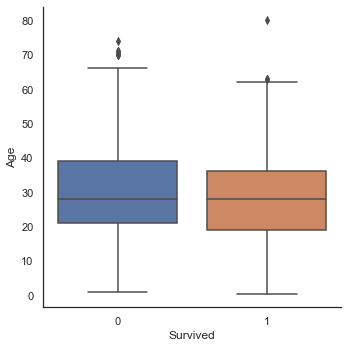

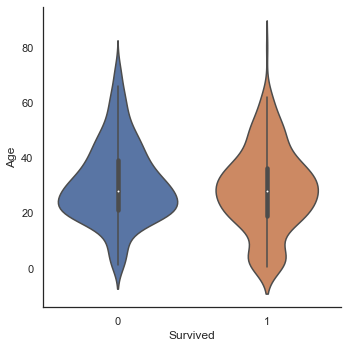

In [41]:
g = sns.catplot(x="Survived", y="Age", data=train, kind="box")
g = sns.catplot(x="Survived", y="Age", data=train, kind="violin")

- 생존 하위 모집단과 생존하지 못한 하위 모집단의 연령 중앙값 사이에는 차이가 없다.
- 그러나 생존한 승객의 바이올린 플롯에서 여전히 아주 어린 승객이 더 높은 생존율을 가지고 있음을 알 수 있다.

# 05. Feature engineering
## 5.1 Name / Title

In [60]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

- Name feature에는 승객의 직위에 대한 정보가 포함되어 있다.
- 대피 시 특별한 직함을 가진 일부 승객이 선호될 수 있으므로 이들을 모델에 추가하는 것은 흥미로운 일이다.

In [61]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

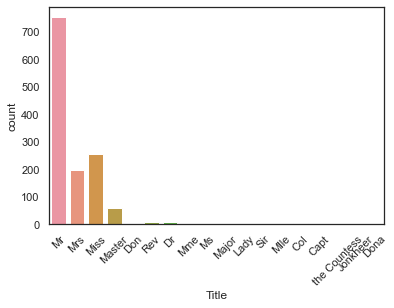

In [62]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

- 데이터 세트에는 17개의 제목이 있으며 대부분은 매우 드물고 4개의 범주로 그룹화할 수 있다.

In [63]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

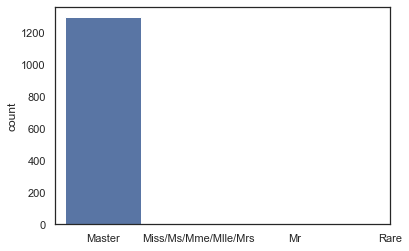

In [64]:
g = sns.countplot(dataset["Title"])
g.set_xticks([0, 1, 2, 3])  # 눈금 위치 설정
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])
plt.show()

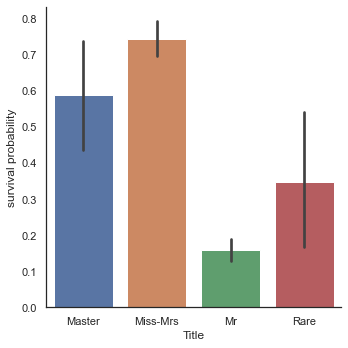

In [66]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

- "Women and children first"

In [67]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

## 5.2 Family size
- 대가족이 대피하는 동안 자매/형제/부모를 찾기 위해 대피하는 데 더 많은 어려움을 겪을 것이라고 상상할 수 있다. 그래서 SibSp, Parch 및 1(승객 포함)의 합계인 "Fize"(가족 규모) feature을 만들기로 선택.

In [68]:
# Create a family size descriptor from SibSp and Parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


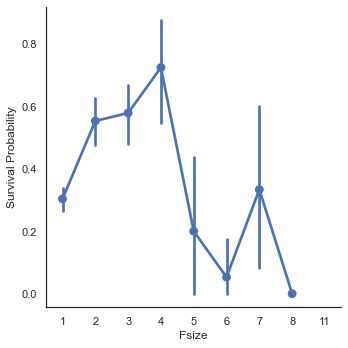

In [70]:
g = sns.catplot(x="Fsize",y="Survived",data=dataset, kind="point")
g = g.set_ylabels("Survival Probability")

- 가족 규모는 중요한 역할을 하는 것으로 보이며 대가족의 경우 생존 확률이 최악이다.
- 또한 가족 규모의 4가지 범주를 만들기

In [71]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s : 1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s : 1 if s==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s : 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s : 1 if s >= 5 else 0)

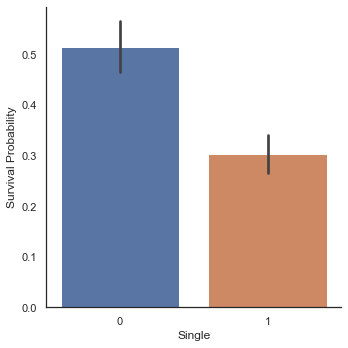

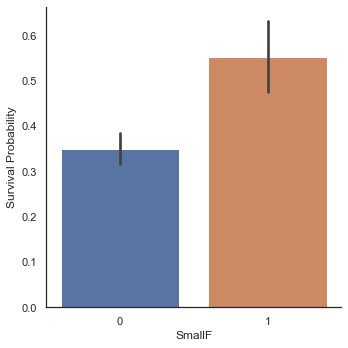

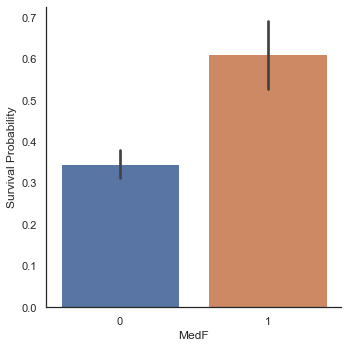

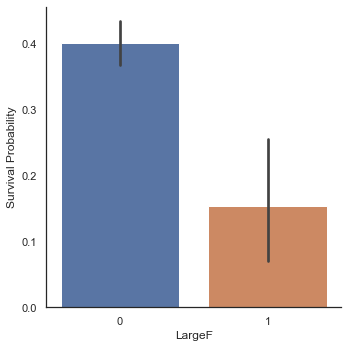

In [72]:
g = sns.catplot(x="Single",y="Survived",data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.catplot(x="SmallF",y="Survived",data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.catplot(x="MedF",y="Survived",data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.catplot(x="LargeF",y="Survived",data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

- 가족 규모 범주는 중소형 가족이 1인 승객 및 대가족보다 생존 가능성이 더 높다는 것을 보여준다.

In [73]:
# Covert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns=["Title"])
dataset = pd.get_dummies(dataset, columns=["Embarked"],prefix="Em")

In [74]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


## 5.3 Cabin

In [75]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [76]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [77]:
dataset["Cabin"].isnull().sum()

1007

- Cabin feature column에는 292개의 값과 1007개의 누락된 값이 있다.
- 객실이 없는 승객에게는 객실 번호 대신 누락된 값이 표시된다고 가정

In [78]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [82]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

- 선실의 첫 글자는 데스크를 나타낸다. 
- 타이타닉에 탑승한 승객의 가능한 위치를 나타내기 때문에 이 정보만 유지

In [83]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

ValueError: Input data must be a pandas object to reorder

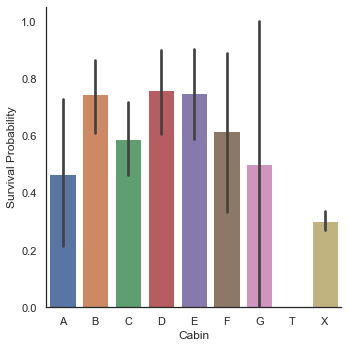

In [85]:
g = sns.catplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

- 객실을 소유한 승객의 수가 적기 때문에 생존 확률은 중요한 표준 편차를 가지며 서로 다른 책상에 있는 승객의 생존 확률을 구분할 수 없다.
- 그러나 객실이 있는 승객은 일반적으로 (X)가 없는 승객보다 생존 가능성이 더 높다는 것을 알 수 있다.
- 객실 B, C, D, E, F의 경우 특히 그렇다.

In [86]:
dataset = pd.get_dummies(dataset, columns=["Cabin"],prefix="Cabin")

## 5.4 Ticket

In [87]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

- 이는 동일한 접두사를 공유하는 티켓이 함께 배치된 객실에 대해 예약될 수 있음을 의미할 수 있다. 따라서 선박 내 캐빈의 실제 배치로 이어질 수 있다.
- 동일한 접두사를 가진 티켓은 비슷한 클래스와 survival을 가질 수 있다.
- 그래서 티켓 기능 열을 티켓 접두사로 바꾸기로 결정

In [88]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) # Take prefix
    else:
        Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [89]:
dataset = pd.get_dummies(dataset, columns=["Ticket"],prefix="T")

In [90]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns=["Pclass"],prefix="Pc")

In [92]:
# Drop useless variables
dataset.drop(labels=["PassengerId"], axis=1, inplace = True)

In [93]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 06. MODELING

In [94]:
## Separag=te train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis=1, inplace=True)

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [95]:
## Separate train feature and label

train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop(labels=["Survived"],axis=1)

/var/folders/qg/syyr2wld1c5gxxwxs5pkpty80000gn/T/ipykernel_36343/602611353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Survived"] = train["Survived"].astype(int)


## 6.1 Simple modeling
### 6.1.1 Cross validate models
We compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.  
- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceptron (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [96]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [102]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

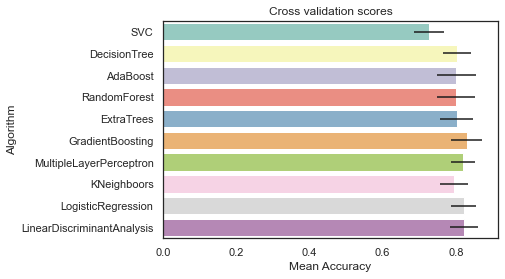

In [104]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

- 앙상블 모델링을 위해 SVC, AdaBoost, RandomForest, ExtraTrees 및 GradientBoosting 분류자를 선택

### 6.1.2 Hyperparameter tunning for best models
a grid search optimization for AdaBoost, ExtraTrees , RandomForest, GradientBoosting and SVC classifiers.

In [105]:
### META MODELING WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion":["gini","entropy"],
                  "base_estimator__splitter":["best","random"],
                  "algorithm":["SAMME","SAMME.R"],
                  "n_estimators":[1,2],
                  "learning_rate":[0.0001,0.001,0.01,0.1,0.2,0.3,1.5]}
gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid,cv=kfold,scoring="accuracy",n_jobs=4,verbose=1)
gsadaDTC.fit(X_train,Y_train)
ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [106]:
gsadaDTC.best_score_

0.8275536261491316

In [108]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {
    "max_depth":[None],
    "max_features":[1,3,10],
    "min_samples_split":[2,3,10],
    "min_samples_leaf":[1,3,10],
    "bootstrap":[False],
    "n_estimators":[100,300],
    "criterion":["gini"]}
gsExtC = GridSearchCV(ExtC,param_grid=ex_param_grid,cv=kfold,scoring="accuracy",n_jobs=4,verbose=1)
gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.833158835546476

In [111]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8320224719101124

In [112]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss':["deviance"],
                 'n_estimators':[100,200,300],
                 'learning_rate':[0.1,0.05,0.01],
                 'max_depth':[4,8],
                 'min_samples_leaf':[100,150],
                 'max_features':[0.3,0.1]
                }
gsGBC = GridSearchCV(GBC,param_grid=gb_param_grid,cv=kfold,scoring="accuracy",n_jobs=4,verbose=1)
gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

0.8320097037793668

In [113]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel':['rbf'],
                 'gamma':[0.001,0.01,0.1,1],
                 'C':[1,10,50,100,200,300,1000]}
gsSVMC = GridSearchCV(SVMC,param_grid=svc_param_grid,cv=kfold,scoring="accuracy",n_jobs=4,verbose=1)
gsSVMC.fit(X_train, Y_train)
SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

### 6.1.3 Plot learning curves
Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be remo

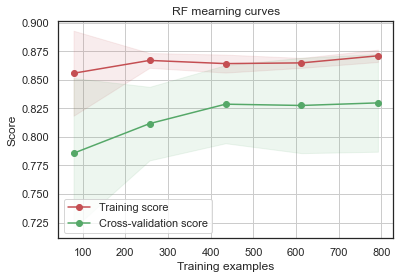

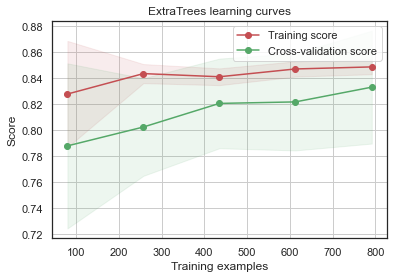

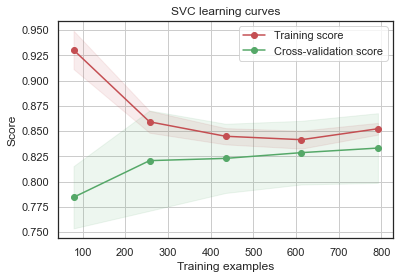

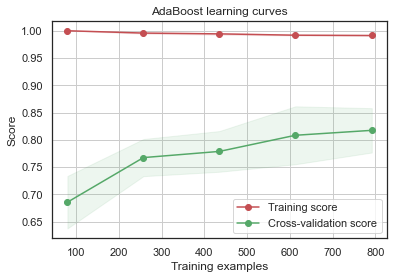

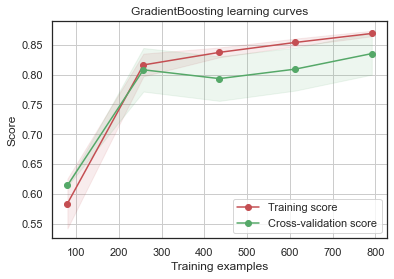

In [115]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

- GradientBoosting 및 Adaboost 분류기는 훈련 세트에 과적합되는 경향이 있다. 증가하는 교차 검증 곡선에 따르면 GradientBoosting 및 Adaboost는 더 많은 훈련 예제로 더 나은 성능을 발휘할 수 있다.
- SVC 및 ExtraTrees 분류기는 훈련 및 교차 검증 곡선이 서로 가깝기 때문에 예측을 더 잘 일반화하는 것 같다.

### 6.1.4 Feature importance of tree based classifiers
승객 생존 예측에 가장 유용한 특징을 보기 위해 4개의 트리 기반 분류기에 대한 특징 중요도를 표시

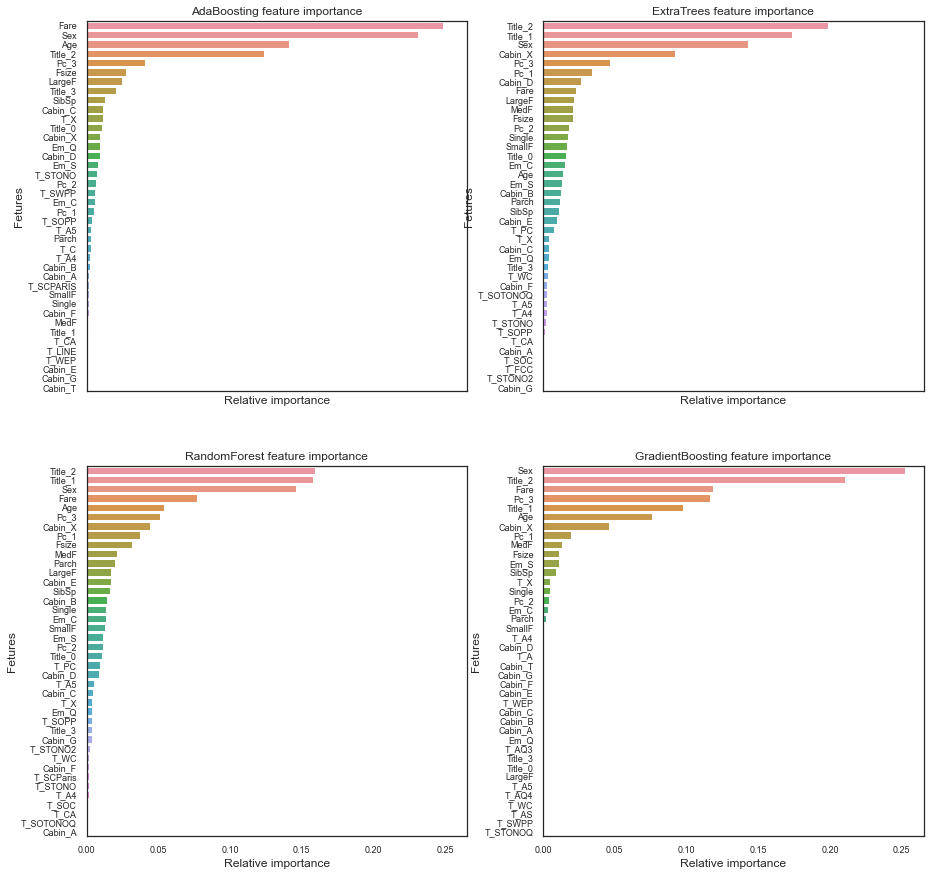

In [116]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex="all",figsize=(15,15))

names_classifiers = [("AdaBoosting",ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]
nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40], orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Fetures",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name+" feature importance")
        nclassifier +=1

- 4개의 트리 기반 분류기(Adaboost, ExtraTrees, RandomForest 및 GradientBoosting)에 대한 기능 중요도를 플로팅.
- 4개의 분류기는 상대적인 중요도에 따라 상위 기능이 다르다. 이는 그들의 예측이 동일한 기능을 기반으로 하지 않는다는 것을 의미한다. 그럼에도 불구하고 그들은 'Fare', 'Title_2', 'Age' 및 'Sex'와 같은 분류에 대한 몇 가지 공통적인 중요한 기능을 공유한다.
- Mrs/Mlle/Mme/Miss/Ms 카테고리를 나타내는 Title_2는 Sex와 높은 상관관계가 있다.
- Pc_1, Pc_2, Pc_3 및 Fare는 승객의 일반적인 사회적 지위를 나타낸다.
- 성별 및 Title_2(Mrs/Mlle/Mme/Miss/Ms) 및 Title_3(Mr)은 성별을 나타낸다.
- 연령 및 Title_1(마스터)은 승객의 연령을 나타낸다.
- Fsize, LargeF, MedF, Single은 승객 패밀리의 크기를 나타낸다.  


이 4가지 분류기의 특성 중요도에 따르면 생존 예측은 보트의 위치보다 승객의 연령, 성별, 가족 규모 및 사회적 지위와 더 관련이 있는 것으로 보인다.

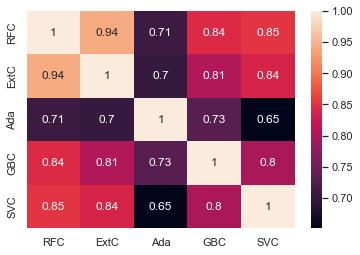

In [117]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

- Adaboost가 다른 분류기와 비교되는 경우를 제외하고 5개의 분류기에 대한 예측은 매우 유사한 것으로 보인다.

- 5개의 분류기는 거의 동일한 예측을 제공하지만 약간의 차이가 있다. 5개의 분류기 예측 간의 이러한 차이는 앙상블 투표를 고려하기에 충분하다.

## 6.2 Ensemble modeling
### 6.2.1 Combining models
- 5개의 분류기에서 나오는 예측을 결합하기 위해 투표 분류기 선택
- 각 투표의 확률을 고려하기 위해 투표 매개변수에 "soft"라는 인수 전달

In [118]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


## 6.3 Prediction
### 6.3.1 Predict and Submit results

In [119]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)